* Live edited version of the ipynb:
https://colab.research.google.com/drive/1wLjS2MeHaJDcqZ6zQOfb7TlQ4uBt9L81
* The empty ipynb for you to start from in Grant's repo: https://github.com/grantmlong/itds2018

# Setting the stage

In [1]:
import sys
sys.version

'3.6.6 |Anaconda custom (64-bit)| (default, Jun 28 2018, 11:07:29) \n[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]'

In [ ]:
# if running on colab, we'll install pytorch right here right now
# if running locally, pip install this in your conda environment.
# note we're installing the bleeding edge 1.0.0 pre-release, official release coming soon.
# !pip install torchvision
# !pip install torch_nightly -f https://download.pytorch.org/whl/nightly/cu92/torch_nightly.html

In [2]:
import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
print(torch.__version__)

%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

1.0.0.dev20181130


# Torch and autograd basics

Torch is a package that defines vectors, matrices, or in general "tensors". If you know numpy, you will not be surprised by any of these:

In [3]:
a = torch.ones(3,3)
a

tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]])

In [4]:
b = torch.arange(9).float().view(3,3)
b

tensor([[0., 1., 2.],
        [3., 4., 5.],
        [6., 7., 8.]])

In [5]:
(a+b)**2

tensor([[ 1.,  4.,  9.],
        [16., 25., 36.],
        [49., 64., 81.]])

In [6]:
b[:,0]

tensor([0., 3., 6.])

In [7]:
a.zero_() # operations with an underscore modify the Tensor in place.
a

tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]])

You can slice and dice tensors and they have roughly all tensor operations you expect equivalently to numpy, but with a bit more low level control. If you need more intro: https://pytorch.org/tutorials/beginner/blitz/tensor_tutorial.html#sphx-glr-beginner-blitz-tensor-tutorial-py

So what's the big deal about pytorch?

**autograd = automatic differentiation**.

Every `torch.Tensor`, let's say `x`, has an important flag `requires_grad`. If this flag is set to True, pytorch will keep track of the graph of operations that happen with this tensor.
When we finally arrive at some output (a scalar variable based on a sequence of operations on `x`), we can call `.backward()` on this output, to compute the gradient `d(output) / dx`. This gradient will end up in `x.grad`.

In [8]:
x = torch.randn(2,2, requires_grad=True)
x

tensor([[-1.8373,  0.5334],
        [-1.1184,  0.1904]], requires_grad=True)

In [9]:
y=(x**2 + x)
z = y.sum()
z

tensor(2.7154, grad_fn=<SumBackward0>)

We know from high school math that the derivative `dz / dx[i,j]` = 2*x +1

In [10]:
z.backward()
x.grad

tensor([[-2.6746,  2.0669],
        [-1.2369,  1.3807]])

In [11]:
2*x+1

tensor([[-2.6746,  2.0669],
        [-1.2369,  1.3807]], grad_fn=<AddBackward0>)

What about the intermediate variable y? Does it require a gradient?

In [12]:
y.requires_grad

True

However the gradient of y is not exposed, since it is an intermediary variable, the result of an operation on leaf variables. Leaf variables are inputs to the operations: the data X or the `Parameter`s of a neural network.

More about autograd in the tutorial https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html#sphx-glr-beginner-blitz-autograd-tutorial-py and the docs https://pytorch.org/docs/stable/autograd.html

In the lecture we talked about how derivatives and backpropagation (based on the chain rule of differentiation) play a central role in deep learning. You can now start to see how this autograd will be massively powerful to define neural networks with weights `W` and optimize them based on the gradients in `W.grad`.

Let's try this for a simple linear mapping `y = W x `, where we want to optimize W:

In [126]:
torch.manual_seed(23801)
x = torch.Tensor([ [1, 0], [2, 0], [3, 0], [-3, 0], [-2, 0] ]) + 0.3*torch.randn(5,2)
y = torch.Tensor([3, 6, 9, -9, -6])
# clearly the right relationship is y  = 3*x[:,0] + 0 * x[:,1].  So we can see that the optimal W = [3,0]
W = torch.randn(1,2, requires_grad=True)
# we start W at random initialization, the gradient will point us in the right direction.
W

tensor([[0.3611, 0.1379]], requires_grad=True)

In [146]:
ypred = x @ W.t()
print(ypred.squeeze())
loss = ((ypred.squeeze()-y)**2).mean() # mean squared error.
loss += 0.1 * W.norm() # stabilization term leading to weight decay
loss.backward()
print(W.grad)
# let's move W in that direction
W.data -= 0.1 * W.grad.data
W.grad.data.zero_()
print(W)

tensor([ 1.9319,  5.6301,  9.5187, -8.3934, -6.5530],
       grad_fn=<SqueezeBackward0>)
tensor([[0.0006, 0.0183]])
tensor([[2.7239, 0.0157]], requires_grad=True)


you can re-execute this cell above a couple of times and see how W oscillates around the optimal value of `[3,0]`.

torch defines `Module`s which do two things: (a) they contain the learnable weight, and (b) define how they operate on an input tensor to give an output.
In this case this would be a `Linear` layer, reducing 2D datapoints `x` to 1D output `y`.

In [147]:
linear = nn.Linear(2,1, bias=False)
linear.weight.data.copy_(W) # we re-initialize the linear layer with the W we just found
ypred = linear(x)
ypred

tensor([[ 1.9321],
        [ 5.6309],
        [ 9.5187],
        [-8.3928],
        [-6.5530]], grad_fn=<MmBackward>)

Now you could do the same thing, compute MSE loss and backprop, then update the linear layer's weight which you can access like this:

In [148]:
linear.weight

Parameter containing:
tensor([[2.7239, 0.0157]], requires_grad=True)

Oh btw let's compare this to the typical solution using moore penrose pseudo inverse https://en.wikipedia.org/wiki/Ordinary_least_squares#Estimation

In [150]:
W_opt = torch.pinverse(x.t() @ x) @ x.t() @ y
W_opt

tensor([ 2.7281, -0.0924])

heh ok we got quite close at least for the first component. The deviation from [3,0] is bc the noise we added with ` + 0.3*torch.randn(5,2)`

# Revisiting KIVA logistic regression from lab 6/7

## sklearn solution

In [122]:
# if you downloaded the kiva data locally, you can skip wget and just set the path
!wget https://grantmlong.com/data/kiva_kenya_sample.csv

--2018-12-03 20:36:45--  https://grantmlong.com/data/kiva_kenya_sample.csv
Resolving grantmlong.com... 99.84.104.80, 99.84.104.77, 99.84.104.41, ...
Connecting to grantmlong.com|99.84.104.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19271835 (18M) [text/csv]
Saving to: 'kiva_kenya_sample.csv'

kiva_kenya_sample.c 100%[=====================>]  18.38M  4.70MB/s   in 4.0s   

2018-12-03 20:36:49 (4.64 MB/s) - 'kiva_kenya_sample.csv' saved [19271835/19271835]



In [151]:
# So here i copy pasted the lab 6/7 logistic regression code where we leave the
# model fitting to sklearn.
data_path = 'kiva_kenya_sample.csv'
df = pd.read_csv(data_path)
print(df.shape)
print(list(df))
df['success'] = (df.STATUS=='funded')*1
df['posted_year'] = pd.to_datetime(df.POSTED_TIME).dt.year
df['posted_duration'] = (pd.to_datetime(df.PLANNED_EXPIRATION_TIME)
                             - pd.to_datetime(df.POSTED_TIME)
                            ).dt.days
model_columns = ['LOAN_AMOUNT', 'posted_year', 'posted_duration', 'LENDER_TERM']
valids = df[model_columns].notna().all(axis=1)
X = df.loc[valids, model_columns].values
X_scaled = preprocessing.scale(X) # zero mean, unit variance

y = df.loc[valids, 'success'].values
X_train_np, X_test_np, y_train_np, y_test_np = train_test_split(
    X_scaled, y, test_size=0.2, random_state=1235)

# OK data is ready, set up the logistic regression classifier and train it.
clf = LogisticRegression(random_state=20181022, multi_class='multinomial', solver='lbfgs')
clf.fit(X_train_np, y_train_np)
W, b = clf.coef_, clf.intercept_
print('The train accuracy of the sklearn model is %0.1f%%' % (clf.score(X_train_np, y_train_np)*100))
print('The test  accuracy of the sklearn model is %0.1f%%' % (clf.score(X_test_np, y_test_np)*100))
print('The learned model: y=W*x+b where \nW={} and \nb={}'.format(W,b))

(18000, 25)
['LOAN_ID', 'DESCRIPTION', 'FUNDED_AMOUNT', 'LOAN_AMOUNT', 'STATUS', 'ACTIVITY_NAME', 'SECTOR_NAME', 'LOAN_USE', 'TOWN_NAME', 'CURRENCY', 'PARTNER_ID', 'POSTED_TIME', 'PLANNED_EXPIRATION_TIME', 'DISBURSE_TIME', 'RAISED_TIME', 'LENDER_TERM', 'NUM_LENDERS_TOTAL', 'NUM_JOURNAL_ENTRIES', 'NUM_BULK_ENTRIES', 'TAGS', 'BORROWER_NAMES', 'BORROWER_GENDERS', 'BORROWER_PICTURED', 'REPAYMENT_INTERVAL', 'DISTRIBUTION_MODEL']
The train accuracy of the sklearn model is 74.1%
The test  accuracy of the sklearn model is 73.9%
The learned model: y=W*x+b where 
W=[[-0.86315581 -0.31378007  1.40152121  0.00639332]] and 
b=[0.36759933]


* How many parameters (weights) does our logistic regression model have? How many  datapoints did we train on?
* Old-skool machine learning rule of thumb is: you can optimize about as many parameters (weights) as you have datapoints before you can memorize the dataset (thus overfit heavily). Are we close to the limit?
* Does the model overfit?
* In deep neural networks you can easily have way more parameters than datapoints. Is overfitting an issue for neural networks?

In [ ]:
# number of parameters is defined by weight and bias dimensionalities.

## torch version of logistic regression

Ok so above we used the sklearn implementation for logistic regression, which optimizes  $$\mathcal{L(W,b)} = \sum_{x,y_{t} \in D} \ell(x,y_t; W,b)$$
with $$\ell(x,y_t; W,b) = \text{CE}(\sigma(Wx+b) || y_t)$$
So per sample, the sigmoid of the linear transformation $\sigma(Wx+b)$ is the model's prediction of the probability.  This is being compared to the true label $y_t$,
by the Cross-Entropy loss: $\text{CE}(\sigma(Wx+b) || y_t)$.

Now we'll set up a small neural network, and optimize the same loss with SGD. We will compare the solution to the one found by sklearn.

We will follow the typical training procedure for a neural network which is as follows:

* Define the neural network that has some learnable parameters (or weights)
* Iterate over a dataset of inputs
* Process input through the network
* Compute the loss (how far is the output from being correct)
* Propagate gradients back into the network’s parameters
* Update the weights of the network, typically using a simple update rule: weight = weight - learning_rate * gradient


In [153]:
X_train, X_test = torch.from_numpy(X_train_np).float(), torch.from_numpy(X_test_np).float()
y_train, y_test = torch.from_numpy(y_train_np).int(),   torch.from_numpy(y_test_np).int()
# we will define a "neural network" of 1 layer:
torch.manual_seed(1238)
net = nn.Linear(4,1) # computes W X + b where X is a (batch of) 4D vectors and y will be 1D.
sigmoid = nn.Sigmoid()
loss = nn.BCELoss() # Binary Cross Entropy Loss

Print the value of the weight and the bias of the network. Do they have any gradients right now?

In [154]:
# For most modules, they're called .weight and .bias
# gradients are an attribute of a Parameter (weight) and are accessible in .grad
print(net.weight)
print(net.bias)

Parameter containing:
tensor([[-0.0449,  0.3682, -0.3248,  0.3429]], requires_grad=True)
Parameter containing:
tensor([-0.4080], requires_grad=True)


In [155]:
def print_accs(net, s=''):
    global X_train, X_test, y_train, y_test
    # net(x) is continuous value, threshold at 0 to make binary prediction
    pred_train = (net(X_train) > 0).squeeze().int()
    acc_train = (pred_train == y_train).float().mean()
    print('Train accuracy is %0.1f%%  - %s' % (acc_train*100, s))
    net.eval()
    pred_test = (net(X_test) > 0).squeeze().int()
    acc_test = (pred_test == y_test).float().mean()
    print('Test  accuracy is %0.1f%%  - %s' % (acc_test*100, s))
    net.train()
# let's print the accuracies for the untrained net, which will be random guess
print_accs(net, 'just initialized')

Train accuracy is 36.9%  - just initialized
Test  accuracy is 37.5%  - just initialized


In [157]:
# sklearn hides everything from you. Let's copy the weights into a torch network
# and compute accuracies ourselves.
refnet = nn.Linear(4,1)
W, b = clf.coef_, clf.intercept_
refnet.weight.data.copy_(torch.from_numpy(W))
refnet.bias.data.copy_(torch.from_numpy(b))
print(refnet.weight) # from the sklearn optimized model
print_accs(refnet, 'sklearn weights copied over into refnet')

Parameter containing:
tensor([[-0.8632, -0.3138,  1.4015,  0.0064]], requires_grad=True)
Train accuracy is 74.1%  - sklearn weights copied over into refnet
Test  accuracy is 73.9%  - sklearn weights copied over into refnet


Now we'll optimize the weights and bias with SGD. Dataset and DataLoader are abstractions to help us iterate over the data in random order. We will do 1 epoch, i.e. we go through the data only once, in minibatches of size 32.

In [160]:
torch.manual_seed(1238)
net = nn.Linear(4,1) # re initialize the net from scratch
print('Just initialized: weight: ', net.weight, '\nbias: ', net.bias)
w, b = net.weight, net.bias 
lr = 1.0
dl = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=True)
print_accs(net, 'before epoch')
for x,ytarget in dl:
    ypred = sigmoid(net(x).squeeze(1)) # forward, pytorch constructs the graph
    output = loss(ypred, ytarget.float()) # forward, pytorch constructs the graph
    output.backward() # backward, pytorch computes net.weight.grad and net.bias.grad
    # access to the weight & bias tensors outside of pytorch autograd
    w, grad_w, b, grad_b = net.weight.data, net.weight.grad.data, net.bias.data, net.bias.grad.data
    # TODO: do an SGD step for both weight and bias: w -= lr * grad
    w -= lr * grad_w # in place modification
    b -= lr*grad_b   # in place modification
    # you could also do
    #net.weight.data = w - lr * grad_w
    #net.bias.data   = b - lr * grad_b
    # TODO: manually clear the gradient of the weight and the bias (use `.zero_()` method) 
    grad_w.zero_()
    grad_b.zero_()
    # we need to do this before doing the forward and backward pass.
print_accs(net, 'after epoch')
print('weight: ', net.weight, '\nbias: ', net.bias)

Just initialized: weight:  Parameter containing:
tensor([[-0.0449,  0.3682, -0.3248,  0.3429]], requires_grad=True) 
bias:  Parameter containing:
tensor([-0.4080], requires_grad=True)
Train accuracy is 36.9%  - before epoch
Test  accuracy is 37.5%  - before epoch
Train accuracy is 73.8%  - after epoch
Test  accuracy is 74.3%  - after epoch
weight:  Parameter containing:
tensor([[-2.5468, -0.4904,  1.5658, -0.1657]], requires_grad=True) 
bias:  Parameter containing:
tensor([0.6778], requires_grad=True)


Ok doing this manually gives you insight what happens down to the gradienst. But usually we do not do these things manually, it would become very cumbersome if the net becomes more complex than the simple linear layer. pytorch gives us primitives to do the same: `net.zero_grad()` to clear the gradients, and for optimization you can do `optimizer.step()` to do a step of SGD.
Again we will do 1 epoch.

In [162]:
list(net.parameters())

[Parameter containing:
 tensor([[-2.5468, -0.4904,  1.5658, -0.1657]], requires_grad=True),
 Parameter containing:
 tensor([0.6778], requires_grad=True)]

In [163]:
torch.manual_seed(1238)
net = nn.Linear(4,1) # re initialize the net from scratch
lr = 1.0
optimizer = torch.optim.SGD(net.parameters(), lr=lr)
dl = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=True)
print_accs(net, 'before epoch')
for x,ytarget in dl:
    ypred = sigmoid(net(x).squeeze(1))
    output = loss(ypred, ytarget.float())
    output.backward()
    # TODO use the gradients to do a step (use the optimizer)
    optimizer.step()
    # TODO clear the gradient
    net.zero_grad()
print_accs(net, 'after epoch')
print('weight: ', net.weight, '\nbias: ', net.bias)

Train accuracy is 36.9%  - before epoch
Test  accuracy is 37.5%  - before epoch
Train accuracy is 73.8%  - after epoch
Test  accuracy is 74.3%  - after epoch
weight:  Parameter containing:
tensor([[-2.5468, -0.4904,  1.5658, -0.1657]], requires_grad=True) 
bias:  Parameter containing:
tensor([0.6778], requires_grad=True)


Ok now let us redo this but for a real 3-layer neural network. You can re-execute the cell a couple of times to do more iterations and see the accuracy improve.

In [165]:
torch.manual_seed(1248)
net = nn.Sequential(
    # first layer
    nn.Linear(4,32),
    nn.Dropout(0.2),
    nn.ReLU(),
    nn.Linear(32,32),
    nn.Dropout(0.2),
    nn.ReLU(),
    # output layer going to 1 prediction
    nn.Linear(32,1),
)
lr = 1.0
optimizer = torch.optim.SGD(net.parameters(), lr=lr)
dl = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=True)
print(net)

Sequential(
  (0): Linear(in_features=4, out_features=32, bias=True)
  (1): Dropout(p=0.2)
  (2): ReLU()
  (3): Linear(in_features=32, out_features=32, bias=True)
  (4): Dropout(p=0.2)
  (5): ReLU()
  (6): Linear(in_features=32, out_features=1, bias=True)
)


In [166]:
# Do 1 epoch:
print_accs(net, 'before epoch')
for x,ytarget in dl:
    ypred = sigmoid(net(x).squeeze(1))
    output = loss(ypred, ytarget.float())
    output.backward()
    optimizer.step()
    net.zero_grad()
print_accs(net, 'after epoch')

Train accuracy is 62.1%  - before epoch
Test  accuracy is 62.1%  - before epoch
Train accuracy is 75.2%  - after epoch
Test  accuracy is 75.0%  - after epoch


And now the final real deal, we train for 10 epochs and cut the learning rate in half between epochs

In [167]:
torch.manual_seed(1248)
net = nn.Sequential(
    nn.Linear(4,16),
#     nn.Dropout(0.1),
    nn.ReLU(),
    nn.Linear(16,32),
#     nn.Dropout(0.1),
    nn.ReLU(),
    nn.Linear(32,16),
    nn.ReLU(),
    # output layer going to 1 prediction
    nn.Linear(16,1),
)
lr = 1.0
optimizer = torch.optim.SGD(net.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)
dl = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=True)
print_accs(net, 'Before training')
for epoch in range(10):
    scheduler.step()
    for x,ytarget in dl:
        ypred = sigmoid(net(x).squeeze(1))
        output = loss(ypred, ytarget.float())
        output.backward()
        optimizer.step()
        net.zero_grad()
    print_accs(net, 'After epoch {}'.format(epoch))

Train accuracy is 37.7%  - Before training
Test  accuracy is 37.9%  - Before training
Train accuracy is 69.8%  - After epoch 0
Test  accuracy is 69.7%  - After epoch 0
Train accuracy is 76.5%  - After epoch 1
Test  accuracy is 76.7%  - After epoch 1
Train accuracy is 78.1%  - After epoch 2
Test  accuracy is 78.0%  - After epoch 2
Train accuracy is 77.2%  - After epoch 3
Test  accuracy is 76.2%  - After epoch 3
Train accuracy is 78.2%  - After epoch 4
Test  accuracy is 78.0%  - After epoch 4
Train accuracy is 78.0%  - After epoch 5
Test  accuracy is 77.9%  - After epoch 5
Train accuracy is 77.9%  - After epoch 6
Test  accuracy is 77.4%  - After epoch 6
Train accuracy is 78.7%  - After epoch 7
Test  accuracy is 78.1%  - After epoch 7
Train accuracy is 78.4%  - After epoch 8
Test  accuracy is 78.0%  - After epoch 8
Train accuracy is 78.9%  - After epoch 9
Test  accuracy is 78.3%  - After epoch 9


Voila and that's how it's done. You can ask yourself some more questions:
* What do we get back from `net.parameters()`: which trainable weights and biases does the network have now? 
* How many total parameters? 
* What happens if you add layers or change the ReLU activation by Sigmoid activation?
* What does the Dropout layer do? 

There are many things you can play around with and where you can dig deeper.

# Now the real stuff: MNIST classification

MNIST is a dataset of 50k handwritten digits (0-9) which is very commonly used in the deep learning community.
It is small enough to work with locally and without much hassle, and complex enough to do something interesting with.

In [168]:
# let's download the MNIST data, if you do this locally and you downloaded before,
# you can change data paths to point to your existing files
train_dataset = dsets.MNIST(root='./MNISTdata',
                           train=True,
                           transform=transforms.ToTensor(),
                           download=True)

test_dataset = dsets.MNIST(root='./MNISTdata',
                           train=False,
                           transform=transforms.ToTensor())

Processing...
Done!


Let's look at the digits and their labels

label: y=6


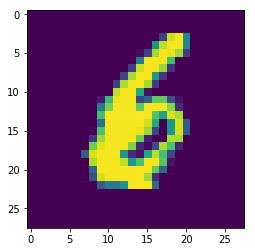

In [169]:
ix=129
x,y = train_dataset[ix]
plt.imshow(x.squeeze().numpy())
print('label: y={}'.format(y))

Now let's define the dataloaders and train simple neural network like before.
You'll recognize that the core is exactly the same: we do a forward pass, compute a loss, backpropagate the loss to compute the gradients, then let the optimizer update the weights.

In [170]:
# The neural network hyperparameters.
input_size    = 784   # The MNIST image size = 28 x 28 = 784
hidden_size   = 100   # The number of nodes at the hidden layer
num_classes   = 10    # The number of output classes. In this case, from 0 to 9
num_epochs    = 5     # The number of times entire dataset is trained
batch_size    = 100   # The number of samples per minibatch
learning_rate = 1.0   # SGD step size

In [171]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=batch_size,
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

In [172]:
len(train_loader)

600

In [174]:
#  define simple MLP network. Train network
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(Net, self).__init__()                    # Inherited from the parent class nn.Module
        self.fc1 = nn.Linear(input_size, hidden_size)  # 1st Full-Connected Layer: 784 (input data) -> 500 (hidden node)
        self.relu = nn.ReLU()                          # Non-Linear ReLU Layer: max(0,x)
        self.fc2 = nn.Linear(hidden_size, num_classes) # 2nd Full-Connected Layer: 500 (hidden node) -> 10 (output class)
    
    def forward(self, x):                              # Forward pass: stacking each layer together
        x = x.view(x.size(0), -1) # flatten (bs x 1 x 28 x 28) -> (bs x 784)
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

def test(net, dl):
    right, tot = 0, 0
    net.eval() # Set dropout and possibly other modules in eval mode.
    for x,y in dl:
        ypred = net(x).argmax(dim=1) # select index of maximal score
        right += (ypred == y).sum().item()
        tot   += x.size(0)
    return 1.* right / tot

In [177]:
device = torch.device('cpu') # if on gpu-enabled machine, set torch.device('cuda')
# create the net based on this class definition
net = Net(input_size, hidden_size, num_classes).to(device)
# define the optimizer
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5)
print('Before training: {:.1f}% test accuracy'.format(100*test(net, test_loader)))
for epoch in range(num_epochs):
    scheduler.step()
    for i, (x,y_target) in enumerate(train_loader):
        y_probs = F.log_softmax(net(x), dim=1) # NOTE 
        output = F.nll_loss(y_probs, y_target)
        output.backward()
        optimizer.step()
        net.zero_grad()
    print('After epoch {}: {:.1f}% test accuracy'.format(epoch, 100*test(net, test_loader)))
print('End of training: {:.1f}% train accuracy'.format(100*test(net, train_loader)))

Before training: 6.7% test accuracy
After epoch 0: 95.4% test accuracy
After epoch 1: 96.9% test accuracy
After epoch 2: 97.2% test accuracy
After epoch 3: 97.4% test accuracy
After epoch 4: 97.5% test accuracy
End of training: 98.4% train accuracy


##  remark after the lab
Make sure to use `log_softmax()` insead of `softmax()`,
which is what nll_loss expects:
https://pytorch.org/docs/master/nn.html#torch.nn.functional.nll_loss


some questions for you to investigate:
* what does softmax do? (test on a random vector)
* what is its purpose? (read the docs)
* what does nll_loss do? can you manually compute it?

Ground truth label: y=8
Model probabilities: 
0: 0.009 / 1: 0.000 / 2: 0.002 / 3: 0.001 / 4: 0.000 / 5: 0.398 / 6: 0.000 / 7: 0.000 / 8: 0.590 / 9: 0.000
Model prediction:  tensor([8])


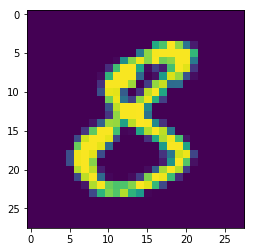

In [176]:
# show the prediction on some samples.
ix=1234
x,y = test_dataset[ix]
plt.imshow(x.squeeze().numpy())
print('Ground truth label: y={}'.format(y))
y_probs = F.softmax(net(x), dim=1)
print ('Model probabilities: ') 
print(' / '.join(['{}: {:.3f}'.format(k,v) 
                  for k,v in zip(range(10), y_probs.squeeze().tolist()) ] ))
print('Model prediction: ', y_probs.argmax(1))

Now we used a simple flat neural network which looks at the image as a flat vector, without awareness of the 2D structure or which pixels neighbor each other.
A convolutional neural network is an architecture that takes the 2D structure of the image into account by sliding a kernel over all the different locations in the image. This kind of neural network has been very succesful in image recognition [1] and speech recognition [2,3].
Pytorch and other deep learning toolboxes are designed to deal with this kind of data and with convolutional neural networks just as easily as with flat data. Try swapping out the network above for a convolutional neural network, see for example the pytorch tutorial [4].

[1] https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks
[2] http://www.cs.toronto.edu/~asamir/papers/icassp13_cnn.pdf
[3] https://arxiv.org/abs/1509.08967
[4] https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html#sphx-glr-beginner-blitz-neural-networks-tutorial-py
[5] https://colab.research.google.com/drive/1jxUPzMsAkBboHMQtGyfv5M5c7hU8Ss2c

In [ ]:
# have fun

# Finishing notes

Inspiration for this lab and the lecture:

*  An old lab I made in lua torch https://github.com/tomsercu/torchtutorial
* This pytorch intro notebook https://colab.research.google.com/drive/1jxUPzMsAkBboHMQtGyfv5M5c7hU8Ss2c
* The official pytorch tutorial https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html
* Yann LeCuns deep learning course in 2015 https://cilvr.nyu.edu/doku.php?id=deeplearning2015:schedule
